# Intro to representation and search

In this notebook, we will explore the concepts of representation and search. We will cover the following topics:

1. Understanding sparse and dense representation
2. Vector embeddings
3. Similarity search
4. Applications

We'll start with an intuitive example and build up to a simple application that uses vector embeddings to find similar content.

# Setup

### Imports

In [1]:
from dataclasses import dataclass, field
from typing import Optional

import matplotlib.pyplot as plt

import numpy as np

from momento_buffconf_workshop import CandyDemo1D, CandyDemoFeatures, jitter, unit_normalize

# One Problem, Many Media

We need a common currency of meaning so "like" can be computed, not hand-waved.

![Similarity Blurb](../images/similarity-blurb.png)

# Embedding Vector = Coordinates in a Meaning Space

How can we capture the various meanings of "like"? Let's try doing this by hand first to get a feel for it.

First we need to decide on something we all like, and then we can describe it in a way that captures its meaning.

Everyone likes candy, right? Let's start there.

How might our inner child lay out a bag of candy on the table?

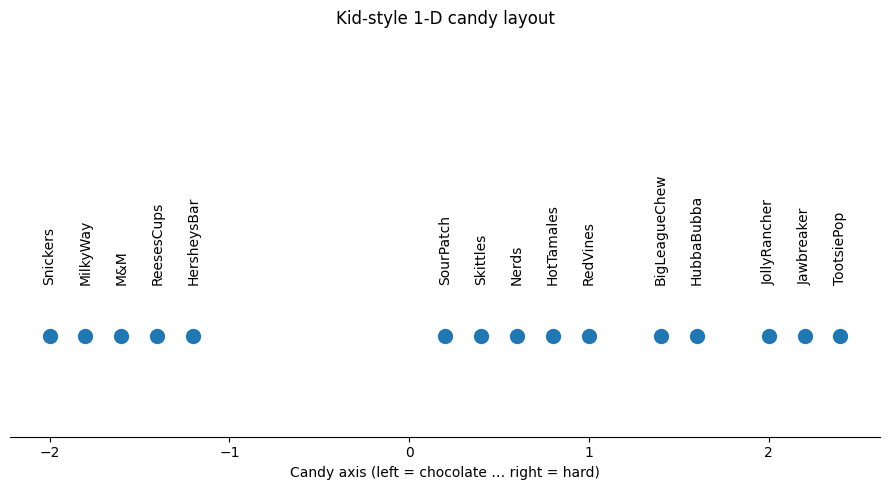

In [2]:
candy_demo_1d = CandyDemo1D()
candy_demo_1d.plot()


This is good! Our inner child has grouped the candy by type:

- Chocolates go together

- Gummies/soft candies go together

- Hard candies go together

We could represent each candy by its placement on the table. To find similar candies to what we like, we can look for candies that are nearby...

This is a good start, but notice that there are many ways we could group the candies. For example, sweet vs sour, chewy vs hard, chocolate vs non-chocolate, etc...

Let's take this a bit further and think about how we might represent the candies in a more structured way.

We can start by thinking about the features of candy, and then use those as a complete description of any particular candy.

In [3]:
candy_features = CandyDemoFeatures()
candy_features.plot_heatmap()

Let's try arranging the candies on a number line. Can we capture the meaning of "like" in a single number?

Chocolate intensity in 1-D separates Snickers from SourPatch nicely, but all sour candies lump at zero.

In [4]:
candy_features.plot_1d(feature="chocolate")

If we flip to the `hard` line (`plot_1d('hard')`), the chocolate bars now collide.

In [5]:
candy_features.plot_1d(feature="hard")

A single number isn't enough. We can group things alike in one way well, but then lose the meaning of "like" in another way.

What if we use two numbers? We can arrange the candies in a grid (plane, 2-D space).

Pick "chocolate" × "sour" → see Snickers (1,0) vs. SourPatch (0,1).

Switch Y-axis to "hard" → see how Jawbreaker pops up at (0,1).

In [6]:
candy_features.plot_2d("chocolate", "sour")

We can make a best effort projection of the candies in a 2-D space using the t-SNE algorithm, which will try to preserve the distances between the candies as much as possible.


Note that _we_ added the color overlay by type. The algorithm doesn't know about types, it just tries to preserve the distances between the candies based on their attributes.

In [7]:
candy_features.plot_projection()

We can see that particular directions in the space encode particular attributes.

### From 2 numbers to hundreds

We fixed the "one-number" problem by giving every candy **two** coordinates.

Real embedding embedding models do the same trick, just scaled up. They learn hundreds or thousands of coordinates (dimensions) at once.

The math and intuition stay identical. We simple add more directions so lots of different "likeness" rules can coexist in the same space.

### Learned embeddings
The more dimensions we add, the more we can capture the meaning of "like", because we can group things that are alike in multiple ways.

What kinds of meaning exist in various modalities?

| Object         | Possible Axes of Meaning        |
| -------------- | ------------------------------- |
| Hot-take tweet | sarcasm, politics, positivity ... |
| YouTube clip   | topic, pace, mood, language, ...  |
| Retail shoe    | style, sport, price-tier, ...     |


In the old days, we hand engineered these axes of meaning (features) like we did above.

Now we can learn them from directly from the data.

**Definition**: An **embedding model** is a function that turns any object into one of these sets of coordinates.



# Vectors are a natural way to represent meaning

You can view a vector in two ways:

1. As a list of numbers representing a point in space.

2. As location pin (on a map) you can also treat as an arrow if you care about direction.

A 1-D point is a number, a 2-D point is a pair of numbers, and so on.

## Length of a vector

The length of a vector is the distance from the origin (0,0,0,...) to the point represented by the vector:

![Length of a vector](https://mathsathome.com/wp-content/uploads/2023/01/how-to-find-the-magnitude-of-a-vector-1024x578.png)

## Cosine similarity (angle between pins)

![pins](https://upload.wikimedia.org/wikipedia/commons/3/32/Pushpins_in_a_map_over_the_U.S.A._%28380092713%29.jpg)

When we view a vector as not just a point in space, but an object with a magnitude (length) and a direction, we can also compute the angle between two vectors.

![Angle between two vectors](../images/cosine-similarity.png)

This is the preferred way of measuring similarity between vectors in many applications, because it is invariant to the magnitude of the vectors.

The mathematical formula for the angle between two vectors is:

```math
\cos(\theta) = \frac{v \cdot w}{\|v\| \|w\|}
```

where \( v \) and \( w \) are the two vectors, the dot is the dot product of the vectors, and \( \|v\| \) and \( \|w\| \) are the magnitudes (lengths) of the vectors.

The dot product is just the sum of the products of the corresponding coordinates of the vectors:

```mathv \cdot w = x_1 \cdot x_2 + y_1 \cdot y_2 + z_1 \cdot z_2 + \ldots
```

Remember the magnitude (length) of a vector is the square root of the sum of the squares of its coordinates:

```math
\|v\| = \sqrt{x_1^2 + y_1^2 + z_1^2 + \ldots}
```

### Interpreting cosine similarity

Cosine similarity is a measure of how similar two vectors are, based on the angle between them. It ranges from -1 to 1:
- 1 means the vectors are pointing in exactly opposite directions (completely dissimilar).
- 0 means the vectors are orthogonal (at a right angle, not similar at all).
- -1 means the vectors are pointing in exactly the same direction (completely similar).

### Cosine similarity vs cosine distance

Cosine similarity is often used to measure the similarity between two vectors and in vector databases. But the range of cosine similarity is from -1 to 1, which can be a bit unintuitive for some applications. Formally this is not a distance metric because it can be negative.

We can convert cosine similarity into a distance metric where it has values between 0 and 1, which is often more intuitive for applications like search. A value of 0 means the vectors are identical, and a value of 1 means they are completely dissimilar. We can use this formula to convert cosine similarity to cosine distance:

```math
\text{cosine\_distance}(v, w) = \frac{1 - \cos(\theta)}{2}
```

For simplicity in the rest of this notebook, we will use cosine similarity as our distance metric, but keep in mind that it can be converted to a distance metric if needed.


In [8]:
snickers = candy_features.features.loc["Snickers"]
snickers

chocolate    1.0
sour         0.0
hard         0.2
gum          0.0
nutty        1.0
Name: Snickers, dtype: float64

In [9]:
m_and_m = candy_features.features.loc["M&M"]
m_and_m

chocolate    1.0
sour         0.0
hard         0.2
gum          0.0
nutty        0.0
Name: M&M, dtype: float64

In [10]:
length_snickers = np.linalg.norm(snickers)
length_m_and_m = np.linalg.norm(m_and_m)
cosine_angle = snickers.dot(m_and_m) / (length_snickers * length_m_and_m) # type: ignore
cosine_angle

np.float64(0.7140055472954167)

# Once everything can be represented as a vector, object similarity = vector similarity

## Similarity in vector space

- **Similarity between objects** = **Similarity between their vector representations**

    `similarity(obj A, obj B) = cosine_similarity(obj A, obj B) = vector(obj A) · vector(obj B) → 0.94`

- **Personalization** = similarity between user-preference vector and candidate content  
    Build user vector → compare to content vectors → top-K nearest neighbors

- **Text search** = nearest neighbour with a text-query vector

- **Clustering / dedup / AB-testing buckets** = group points that sit close together

<sub>All done with the same cosine similarity function.</sub>

## Article content similarity example

Suppose we have a collection of sports articles and want to measure how similar two articles are.

We can represent each article as a vector, then compute their similarity using the cosine of the angle between their vectors:

```similarity(article A, article B) = cosine_similarity(vector(article A), vector(article B))```

Let's organize our data lightly. We will give each article an id, a name, some text, and a vector representation of the text.

This is already a vector database!

In [11]:
@dataclass
class VectorDB:
    vectors: dict[str, np.ndarray] = field(default_factory=dict)
    metadata: dict[str, dict] = field(default_factory=dict)
    ids: set[str] = field(default_factory=set)
    num_dimensions: int = 2

    def upsert(self, id: str, vector: np.ndarray, metadata: dict) -> str:
        """
        Upsert a vector with its ID and metadata.
        If the ID already exists, it replaces the vector and metadata.
        """

        if len(vector) != self.num_dimensions:
            raise ValueError(f"Vector must have {self.num_dimensions} dimensions, got {len(vector)}.")
        self.vectors[id] = vector
        self.metadata[id] = metadata
        self.ids.add(id)

        return id
    
    def upsert_many(self, entries: list[tuple[str, np.ndarray, dict]]) -> None:
        """
        Upsert multiple vectors with their IDs and metadata.
        """
        for (id, vector, metadata) in entries:
            self.upsert(id, vector, metadata)

    def similarity_by_id(self, id_a: str, id_b: str) -> float:
        """
        Compute cosine similarity between two vectors by their IDs.
        """
        vector_a = self.vectors.get(id_a)
        vector_b = self.vectors.get(id_b)
        if vector_a is None or vector_b is None:
            raise ValueError("One or both IDs not found in the database.")

        return VectorDB.cosine_similarity(vector_a, vector_b)
    
    def search(self, query_vector: np.ndarray, limit: int = 5) -> list[tuple[str, float]]:
        """
        Perform a similarity search for a given vector.
        Returns the most similar vectors with their IDs and similarity scores.
        """
        if not self.vectors:
            return []
        
        if len(query_vector) != self.num_dimensions:
            raise ValueError(f"Query vector must have {self.num_dimensions} dimensions, got {len(query_vector)}.")

        similarities = []
        for id, vector in self.vectors.items():
            similarity = VectorDB.cosine_similarity(query_vector, vector)
            similarities.append((id, similarity))

        return sorted(similarities, key=lambda x: x[1], reverse=True)[:limit]


    @staticmethod
    def cosine_similarity(vector_a: np.ndarray, vector_b: np.ndarray) -> float:
        vector_a_norm = np.linalg.norm(vector_a)
        vector_b_norm = np.linalg.norm(vector_b)

        return vector_a.dot(vector_b) / (vector_a_norm * vector_b_norm)
    
    def get_vector_by_id(self, id: str) -> Optional[np.ndarray]:
        """
        Retrieve a vector by its ID.
        Returns None if the ID does not exist.
        """
        return self.vectors.get(id)
    
    def plot_2d(self, extra_vectors: Optional[list[tuple[str, np.ndarray]]] = None) -> None:
        """Plot the vectors in 2D space if they are 2D vectors."""
        if not all(len(v) == 2 for v in self.vectors.values()):
            raise ValueError("All vectors must be 2D for this plot.")
        
        plt.figure(figsize=(8, 8))
        vectors = list(self.vectors.items())
        if extra_vectors:
            if not all(len(v) == 2 for _, v in extra_vectors):
                raise ValueError("All extra vectors must be 2D for this plot.")
            vectors.extend(extra_vectors)
        for id, vector in vectors:
            plt.scatter(vector[0], vector[1], s=120)
            plt.text(vector[0] + 0.01, vector[1] + 0.01, id, fontsize=9)


        plt.xlim(-1.75, 1.75)
        plt.ylim(-1.75, 1.75)
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.title("2D Vector Plot")
        plt.grid()
        plt.show()


We'll fake 2-D vectors so we can see them. A real embedding has more dimensions (eg 1536, 3072) and comes from a model like OpenAI's `text-embedding-3-small`.

In [12]:
vector_db = VectorDB()
vector_db.upsert(
    id="Kansas City Chiefs",
    vector=np.array([1.0, 0.0]),
    metadata={"text": "The Kansas City Chiefs are a professional American football team based in Kansas City, Missouri."}
)
vector_db.upsert(
    id="Buffalo Bills",
    vector=np.array([0.97, 0.26]),
    metadata={"text": "The Buffalo Bills are a professional American football team based in Buffalo, New York."}
)
vector_db.upsert(
    id="Seattle Mariners",
    vector=np.array([-0.71, 0.71]),
    metadata={"text": "The Seattle Mariners are a professional baseball team based in Seattle, Washington."}
)
vector_db.upsert(
    id="Los Angeles Lakers",
    vector=np.array([-0.71, -0.71]),
    metadata={"text": "The Los Angeles Lakers are a professional basketball team based in Los Angeles, California."}
);

In [13]:
vector_db.ids, vector_db.vectors, vector_db.metadata

({'Buffalo Bills',
  'Kansas City Chiefs',
  'Los Angeles Lakers',
  'Seattle Mariners'},
 {'Kansas City Chiefs': array([1., 0.]),
  'Buffalo Bills': array([0.97, 0.26]),
  'Seattle Mariners': array([-0.71,  0.71]),
  'Los Angeles Lakers': array([-0.71, -0.71])},
 {'Kansas City Chiefs': {'text': 'The Kansas City Chiefs are a professional American football team based in Kansas City, Missouri.'},
  'Buffalo Bills': {'text': 'The Buffalo Bills are a professional American football team based in Buffalo, New York.'},
  'Seattle Mariners': {'text': 'The Seattle Mariners are a professional baseball team based in Seattle, Washington.'},
  'Los Angeles Lakers': {'text': 'The Los Angeles Lakers are a professional basketball team based in Los Angeles, California.'}})

We designed the vector representations of the articles so that similar articles have similar vectors. A text embedding model would do this but we did it by hand for demonstration:

- Football teams are alike
- Football and baseball teams are not alike
- Football and basketball teams are not alike
- Baseball and basketball teams are not alike

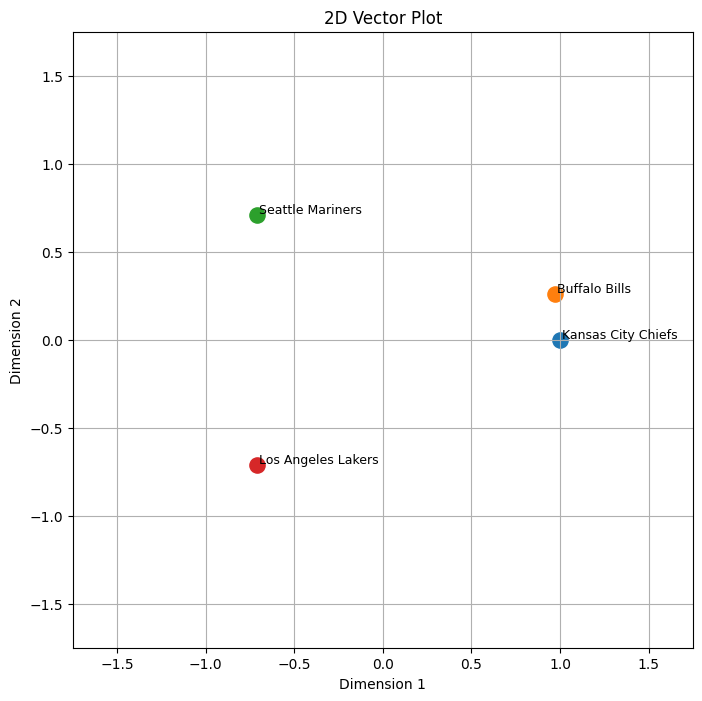

In [14]:
vector_db.plot_2d()

These are two football teams and hence similar:

In [15]:
vector_db.similarity_by_id("Kansas City Chiefs", "Buffalo Bills")

np.float64(0.9659035961548896)

Football and baseball aren't very alike hence dissimilar:

In [16]:
vector_db.similarity_by_id("Kansas City Chiefs", "Seattle Mariners")

np.float64(-0.7071067811865476)

Neither are football and basketball, nor baseball and basketball:

In [17]:
vector_db.similarity_by_id("Kansas City Chiefs", "Los Angeles Lakers")

np.float64(-0.7071067811865476)

In [18]:
vector_db.similarity_by_id("Seattle Mariners", "Los Angeles Lakers")

np.float64(0.0)

Now let's go run a search using a new query vector.

Before that let's add more entries to the database to make it more interesting:

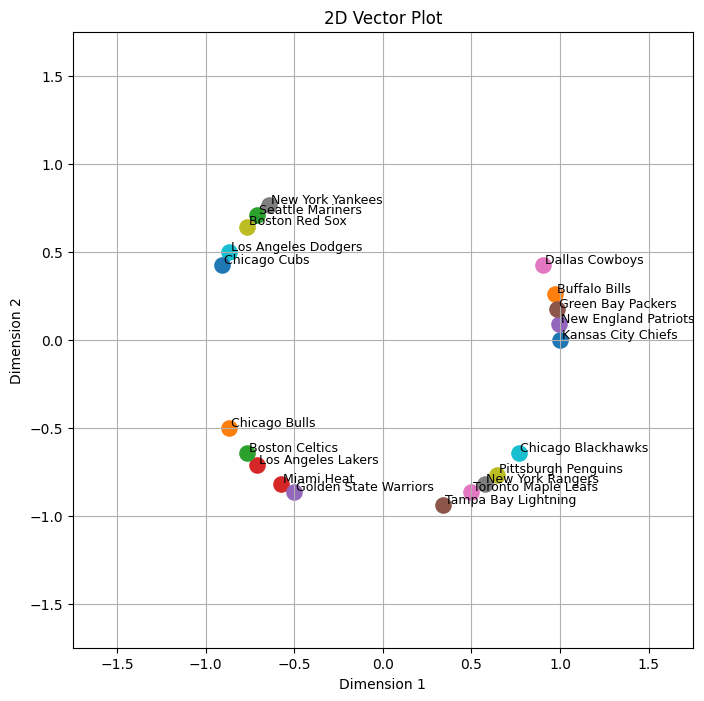

In [19]:
new_entries = [
    # ── football cluster (≈ 0–30 °) ──────────────────────────────────────
    (
        "New England Patriots",
        np.array([0.996, 0.087]),
        {"text": "The New England Patriots are a professional American football team based in Foxborough, Massachusetts."},
    ),
    (
        "Green Bay Packers",
        np.array([0.985, 0.174]),
        {"text": "The Green Bay Packers are a professional American football team based in Green Bay, Wisconsin."},
    ),
    (
        "Dallas Cowboys",
        np.array([0.906, 0.423]),
        {"text": "The Dallas Cowboys are a professional American football team based in Arlington, Texas."},
    ),

    # ── baseball cluster (≈ 130–160 °) ───────────────────────────────────
    (
        "New York Yankees",
        np.array([-0.643, 0.766]),
        {"text": "The New York Yankees are a professional baseball team based in New York City, New York."},
    ),
    (
        "Boston Red Sox",
        np.array([-0.766, 0.643]),
        {"text": "The Boston Red Sox are a professional baseball team based in Boston, Massachusetts."},
    ),
    (
        "Los Angeles Dodgers",
        np.array([-0.866, 0.500]),
        {"text": "The Los Angeles Dodgers are a professional baseball team based in Los Angeles, California."},
    ),
    (
        "Chicago Cubs",
        np.array([-0.906, 0.423]),
        {"text": "The Chicago Cubs are a professional baseball team based in Chicago, Illinois."},
    ),

    # ── basketball cluster (≈ 210–240 °) ────────────────────────────────
    (
        "Chicago Bulls",
        np.array([-0.866, -0.500]),
        {"text": "The Chicago Bulls are a professional basketball team based in Chicago, Illinois."},
    ),
    (
        "Boston Celtics",
        np.array([-0.766, -0.643]),
        {"text": "The Boston Celtics are a professional basketball team based in Boston, Massachusetts."},
    ),
    (
        "Miami Heat",
        np.array([-0.574, -0.819]),
        {"text": "The Miami Heat are a professional basketball team based in Miami, Florida."},
    ),
    (
        "Golden State Warriors",
        np.array([-0.500, -0.866]),
        {"text": "The Golden State Warriors are a professional basketball team based in San Francisco, California."},
    ),

    # ── hockey cluster (≈ 290–320 °) ────────────────────────────────────
    (
        "Tampa Bay Lightning",
        np.array([0.342, -0.940]),
        {"text": "The Tampa Bay Lightning are a professional ice hockey team based in Tampa, Florida."},
    ),
    (
        "Toronto Maple Leafs",
        np.array([0.500, -0.866]),
        {"text": "The Toronto Maple Leafs are a professional ice hockey team based in Toronto, Ontario."},
    ),
    (
        "New York Rangers",
        np.array([0.574, -0.819]),
        {"text": "The New York Rangers are a professional ice hockey team based in New York City, New York."},
    ),
    (
        "Pittsburgh Penguins",
        np.array([0.643, -0.766]),
        {"text": "The Pittsburgh Penguins are a professional ice hockey team based in Pittsburgh, Pennsylvania."},
    ),
    (
        "Chicago Blackhawks",
        np.array([0.766, -0.643]),
        {"text": "The Chicago Blackhawks are a professional ice hockey team based in Chicago, Illinois."},
    ),
]
vector_db.upsert_many(new_entries)
vector_db.plot_2d()

Now let's suppose we have a user that is a baseball fan, and they have a text query that talks about the Seattle Mariners, hence has a vector representation similar to that:

In [20]:
mariners_vector = vector_db.get_vector_by_id("Seattle Mariners")
assert mariners_vector is not None, "Seattle Mariners vector not found."

mariners_vector

array([-0.71,  0.71])

In [21]:
query_vector = jitter(mariners_vector) # type: ignore
query_vector

array([-0.68516429,  0.70308678])

In [22]:
vector_db.search(query_vector, limit=5)

[('Seattle Mariners', np.float64(0.9999166747738675)),
 ('New York Yankees', np.float64(0.99725097689525)),
 ('Boston Red Sox', np.float64(0.9950057005556808)),
 ('Los Angeles Dodgers', np.float64(0.9625076785338935)),
 ('Chicago Cubs', np.float64(0.9353676596358111))]

## Recommendation = user-to-content similarity

### The goal
Suppose we want to build a recommender system for sports articles.

### The problem
We already have a way to represent the article content as vectors and find similar articles to a user query.

For a recommender, we want to do matchmaking between a user (their preferences) and content.

If we can represent user preferences _as a vector in the same space as the content_, then we are almost done!

Given a user preference vector, we do a similarity search against the content to find the most similar articles.

How do we represent user preferences as a vector in content space though?

### How do we get a user preference vector?

A simple way to do this is to use the articles the user has liked or read as a proxy for their preferences:

> Average the vectors of articles the user has liked/read.

### Workflow

- Represent each article as a vector.
- Build a user preference vector over time.
- Search: compute cosine similarity between the user vector and each article vector.
- Recommend: the top-K most similar articles to the user.



Let's say we have a hypothetical user from Chicago. In our production database we know they've read and linked articles on the Chicago Bulls and Chicago Cubs.

Using this we can build a user preference vector by averaging the vectors of the articles they have read:

In [23]:
bulls_vector = vector_db.get_vector_by_id("Chicago Bulls")
cubs_vector = vector_db.get_vector_by_id("Chicago Cubs")
assert bulls_vector is not None and cubs_vector is not None, "Chicago Bulls or Chicago Cubs vector not found."

user_vector = (bulls_vector + cubs_vector) / 2.0
user_vector


array([-0.886 , -0.0385])

Where does this user preference vector sit in the content space?

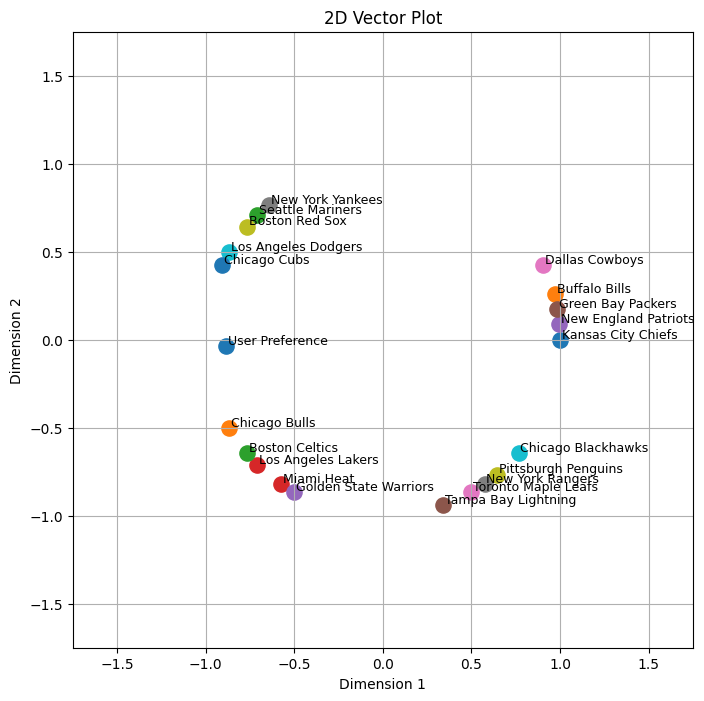

In [24]:
vector_db.plot_2d(extra_vectors=[("User Preference", user_vector)])

Let's recommend some content using the user preference vector:

In [25]:
vector_db.search(user_vector, limit=5)

[('Chicago Bulls', np.float64(0.886909445020787)),
 ('Chicago Cubs', np.float64(0.8868864618902499)),
 ('Los Angeles Dodgers', np.float64(0.8434957325264761)),
 ('Boston Celtics', np.float64(0.7931109452147134)),
 ('Boston Red Sox', np.float64(0.7372878607942321))]

If we had lots of content around the Bulls and Cubs, the user would get recommendations for those articles.

### How else could we build the user preference vector?

However best captures your real user preferences! It's an open design space.

A simple extension to the above is if in our production database we recorded when the user read an article, we could build a user preference vector that is weighted by how much time the user spent reading each article.

For our user above, let's suppose:

| Article ID | Time Spent Reading (minutes) |
| ---------- | ----------------------------- |
| Chicago Bulls | 25.0 |
| Chicago Cubs  | 5.0  |


In [26]:
# From our database:
articles_and_time_spent = {
    "Chicago Bulls": 25.0,
    "Chicago Cubs": 5.0,
}
total_time_spent = 0

# Build the user preference vector weighted by time spent reading each article
user_vector = np.zeros(2)
for (article_name, time_spent) in articles_and_time_spent.items():
    total_time_spent += time_spent
    article_vector = vector_db.get_vector_by_id(article_name)
    assert article_vector is not None, f"Vector for {article_name} not found."

    user_vector += article_vector * time_spent

user_vector /= total_time_spent
user_vector

array([-0.87266667, -0.34616667])

Let's see where the new user preference sits in the content space:

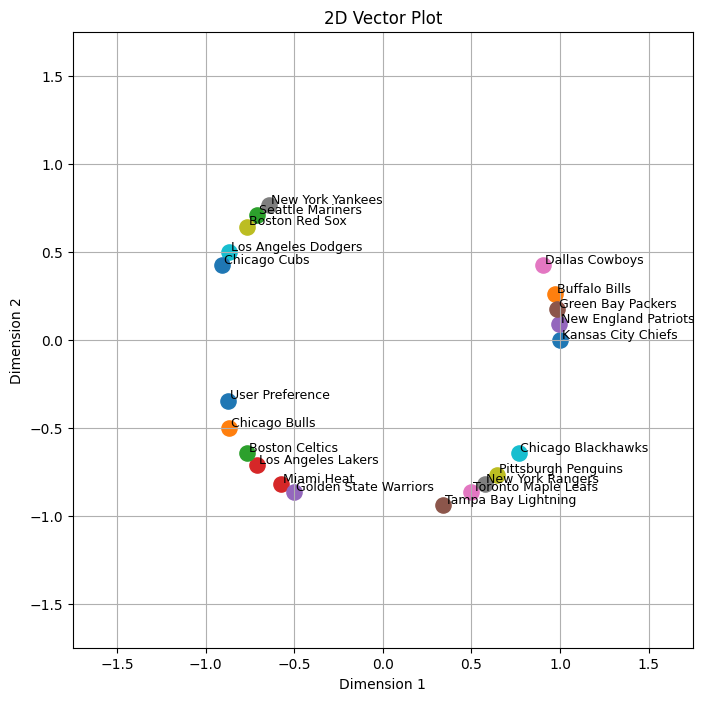

In [27]:
vector_db.plot_2d(extra_vectors=[("User Preference", user_vector)])

In [28]:
vector_db.search(user_vector, limit=10)

[('Chicago Bulls', np.float64(0.9893648228540137)),
 ('Boston Celtics', np.float64(0.9490198329999198)),
 ('Los Angeles Lakers', np.float64(0.918011466664587)),
 ('Miami Heat', np.float64(0.8354426199925213)),
 ('Golden State Warriors', np.float64(0.7841031820073712)),
 ('Chicago Cubs', np.float64(0.6862709143780835)),
 ('Los Angeles Dodgers', np.float64(0.620630485849604)),
 ('Boston Red Sox', np.float64(0.474886504134651)),
 ('Seattle Mariners', np.float64(0.3965538388067046)),
 ('New York Yankees', np.float64(0.31521636469701975))]

The user's preferences now align more with basketball content, so they get recommendations there.

Notice how the Cubs are lower down on the list. That is because our toy vectors are in 2D. In a real system, we would have many more dimensions, and the user preference vector capture more directions of meaning, so Cubs would still be recommended highly.

# Appendix

## $O(1)$ space and time user preferences

### The problem with averaging user preferences
The problem with averaging user preferences is that it requires looking up all the articles the user has read, which can be expensive in terms of both space and time complexity, especially if the user has read many articles.

### Solution: Exponentially Weighted Moving Average (EWMA)
By using an exponentially weighted moving average (EWMA) to build the user preference vector, we can keep the space and time complexity of building the user preference vector at $O(1)$:

$$\text{user\_vector} := \alpha \cdot \text{user\_vector} + (1 - \alpha) \cdot \text{content\_vector}$$

where $\alpha$ is a parameter that controls how much we weight the new content vector vs the existing user vector.

Previously to build the `user_vector` we looked up all the articles the user had read and averaged them.

With this strategy, instead of looking up all the articles the user has read, we "remember" them all in `user_vector` by blending the new article vector into the existing user vector:

- `user_vector` is the current user preference vector

- `content_vector` is the vector of the new article the user has read

- update the `user_vector` by blending it with the new `content_vector`: apply a weighted average based on the parameter $\alpha$.

- set the initial `user_vector` to some default value (eg zero vector, content average, or using a specific strategy)
    - setting the initial value is called the "cold start" problem, and is very important to keep the onboarding experience smooth for new users

### Interpretation of EWMA
Suppose we set $\alpha = 0.9$ and we call the initial `user_vector` is `user_vector_0`. After the user reads a new article with vector `content_vector_1`, we update the `user_vector` as follows:

```python
user_vector_1 = 0.9 * user_vector_0 + 0.1 * content_vector_1
```

And then again with a new article with vector `content_vector_2`:
```python
user_vector_2 = 0.9 * user_vector_1 + 0.1 * content_vector_2
```

When we substitute the first equation into the second, we get:

```python
user_vector_2 = 0.9 * (0.9 * user_vector_0 + 0.1 * content_vector_1) + 0.1 * content_vector_2
```

or
```python
user_vector_2 = 0.9^2 * user_vector_0 + 0.9 * 0.1 * content_vector_1 + 0.1 * content_vector_2
```

Thus after two rounds of updates, the contribution of `user_vector_0` has weight `0.9^2`; content_vector_1 has weight `0.9 * 0.1`, and content_vector_2 has weight `0.1`. Or using our notation, `user_vector_0` has weight $\alpha^2$, `content_vector_1` has weight $\alpha \cdot (1 - \alpha)$, and `content_vector_2` has weight $(1 - \alpha)$.

As we go through more rounds of updates, the contribution of the initial `user_vector_0` will decay exponentially ($\alpha^{num\_updates}$), while the contributions of the new content vectors will be weighted by how recent they are.

That is why this is called an exponentially weighted moving average (EWMA).

In code:

In [29]:
class UserProfile:
    def __init__(self, cold_start_vector: np.ndarray, alpha: float = 0.9):
        """Initialize the user profile with a cold start vector and an alpha value for EWMA.

        Args:
            cold_start_vector (np.ndarray): Initial user preference vector.
            alpha (float, optional): Smoothing factor for EWMA (0 < alpha < 1). Defaults to 0.9.
        """
        self._alpha = alpha
        self._vector = cold_start_vector

    def update(self, content_vector: np.ndarray) -> None:
        self._vector = self._alpha * self._vector + (1 - self._alpha) * content_vector

    @property
    def vector(self) -> np.ndarray:
        """Return the current user preference vector."""
        return unit_normalize(self._vector)
    
    def __repr__(self) -> str:
        return f"UserProfile(vector={self.vector}, alpha={self._alpha})"

In [30]:
user_profile = UserProfile(cold_start_vector=np.array([0.0, 0.0]), alpha=0.9)
user_profile

UserProfile(vector=[0. 0.], alpha=0.9)

In [31]:
user_profile.update(vector_db.get_vector_by_id("Chicago Bulls"))  # type: ignore
user_profile

UserProfile(vector=[-0.86601905 -0.500011  ], alpha=0.9)

In [32]:
user_profile.update(vector_db.get_vector_by_id("Chicago Cubs"))  # type: ignore
user_profile

UserProfile(vector=[-0.99987171 -0.01601788], alpha=0.9)

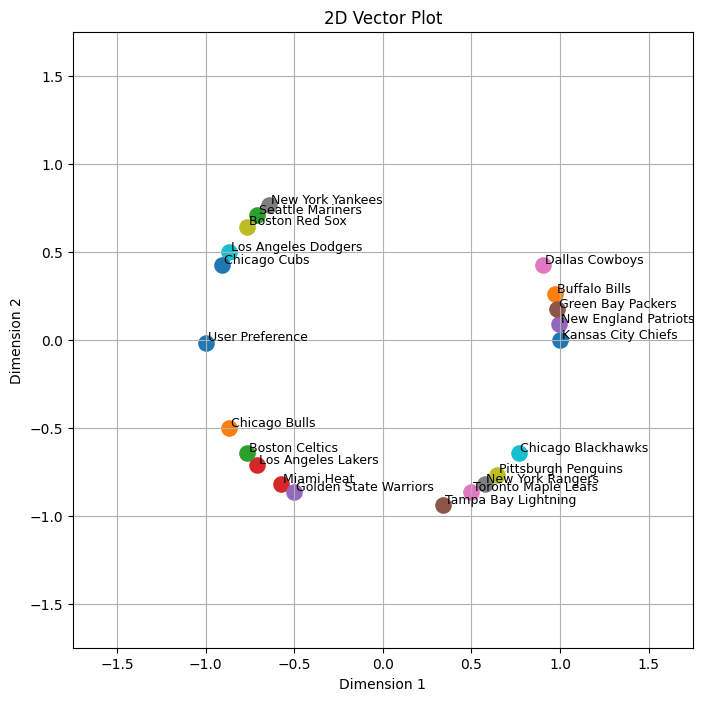

In [33]:
vector_db.plot_2d(extra_vectors=[("User Preference", user_profile.vector)])

Note that the user preference is slightly closer to the Cubs than the Bulls. This is because of the bias the moving average gives to the most recent content vector.

### A note on the "shared space" between content and user preferences

In practice, we need very nuanced user preferences, not just what articles they have read.

Because of this, it is not straightforward to go from user preferences directly to the content space.

We have a special purpose model to align user preferences to content. In other words, we have a new space, the "recommendation space". The model learns to map:

- user preference to recommendation space
- content to recommendation space

We still do a similarity search, but this time in recommendation space.

## Straight line distance
Just as we can find the straight line distance between two points in 2-D space, we can find the distance between two vectors in any number of dimensions.

It's the same formula, just with more numbers:

```math
\text{distance} = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2 + \ldots}
```

You can read this as:

> The distance between two points is the square root of the sum of the squares of the differences between their coordinates.

Or using the definition of vector length above:

> The distance between two vectors is the length of their difference.

Let's apply this to the candy dataset from above.

In [34]:
snickers = candy_features.features.loc["Snickers"]
snickers


chocolate    1.0
sour         0.0
hard         0.2
gum          0.0
nutty        1.0
Name: Snickers, dtype: float64

In [35]:
m_and_m = candy_features.features.loc["M&M"]
m_and_m

chocolate    1.0
sour         0.0
hard         0.2
gum          0.0
nutty        0.0
Name: M&M, dtype: float64

The distance is the:
- square root of the
- sum of the
- squares of the
- differences between the coordinates.

First let's compute this the "old way". Then we'll do it the "Vector Way".

In [36]:
sum_of_squares_of_differences = 0
for (snickers_coordinate, m_and_m_coordinate) in zip(snickers, m_and_m):
    difference = snickers_coordinate - m_and_m_coordinate # type: ignore
    square_of_difference = difference ** 2
    sum_of_squares_of_differences += square_of_difference
distance = sum_of_squares_of_differences ** 0.5
distance

1.0

That for loop is annoying. 

We can use the scientific Python library NumPy apply operations across each coordinate of the vectors identically and simultaneously. This makes our code very compact and efficient.

For systems folks out there, this uses SIMD operations (Single Instruction, Multiple Data) in hardware when available. When not available, intelligent batching is used to speed up the computation. In any case the code is much more readable and maintainable.

In [37]:
# no for loop!

differences = snickers - m_and_m
differences

chocolate    0.0
sour         0.0
hard         0.0
gum          0.0
nutty        1.0
dtype: float64

Squares of the differences:

In [38]:
squares_of_differences = differences**2
squares_of_differences

chocolate    0.0
sour         0.0
hard         0.0
gum          0.0
nutty        1.0
dtype: float64

Sum of the squares of the differences:

In [39]:
sum_of_squares_of_differences = squares_of_differences.sum()
sum_of_squares_of_differences

np.float64(1.0)

Square root of the sum of the squares of the differences:

In [40]:
distance = sum_of_squares_of_differences**0.5
distance

np.float64(1.0)

Thus the straight line distance between Snickers and M&M's is:

```python
((snickers - m_and_m)**2).sum()**0.5
```

That's now a one liner!